In [1]:
%pip install aif360 'aif360[inFairness]' fairlearn --quiet

Note: you may need to restart the kernel to use updated packages.


# 1. Libraries, Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
# from aif360.algorithms.preprocessing import Reweighing
from fairlearn.metrics import MetricFrame, selection_rate, false_negative_rate
# from fairlearn.postprocessing import ThresholdOptimizer


# df = pd.read_csv("/content/sample_data/loan_access_dataset.csv", encoding='latin1')
df = pd.read_csv("/Users/cybernest/Downloads/loan_access_dataset.csv", encoding='latin1')
df['Loan_Approved'] = df['Loan_Approved'].map({'Approved':1, 'Denied':0})
df=df.drop(columns=['ID'])
df.head()


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


,Gender,Race,Age,Age_Group,Income,Credit_Score,Loan_Amount,Employment_Type,Education_Level,Citizenship_Status,Language_Proficiency,Disability_Status,Criminal_Record,Zip_Code_Group,Loan_Approved
0,Female,White,74,Over 60,112117,641,378691,Full-time,Graduate,Citizen,Fluent,No,No,High-income Suburban,1
1,Female,White,36,25-60,155943,664,441856,Self-employed,High School,Permanent Resident,Limited,No,No,Urban Professional,0
2,Female,White,27,25-60,130933,550,401760,Full-time,Graduate,Citizen,Fluent,No,No,Urban Professional,0
3,Male,White,67,Over 60,165816,804,159264,Gig,Some College,Citizen,Fluent,No,No,Urban Professional,1
4,Male,Multiracial,57,25-60,81510,694,256742,Full-time,Some College,Visa Holder,Fluent,No,No,Rural,0


# 2. Data Preprocessing, EDA (mostly)

Feature Group definitions

In [ ]:
# sensitive = privileged and unprivileged groups
sensitive = ['Gender','Race','Age_Group','Citizenship_Status','Disability_Status','Criminal_Record']
# categorical
categorical_cols = ['Gender', 'Race', 'Age_Group', 'Employment_Type', 'Education_Level', 'Citizenship_Status', 'Language_Proficiency', 'Disability_Status', 'Criminal_Record', 'Zip_Code_Group']

# Continuous
continuous_cols = ['Income', 'Credit_Score', 'Loan_Amount']

EDA

1. Categorical EDA

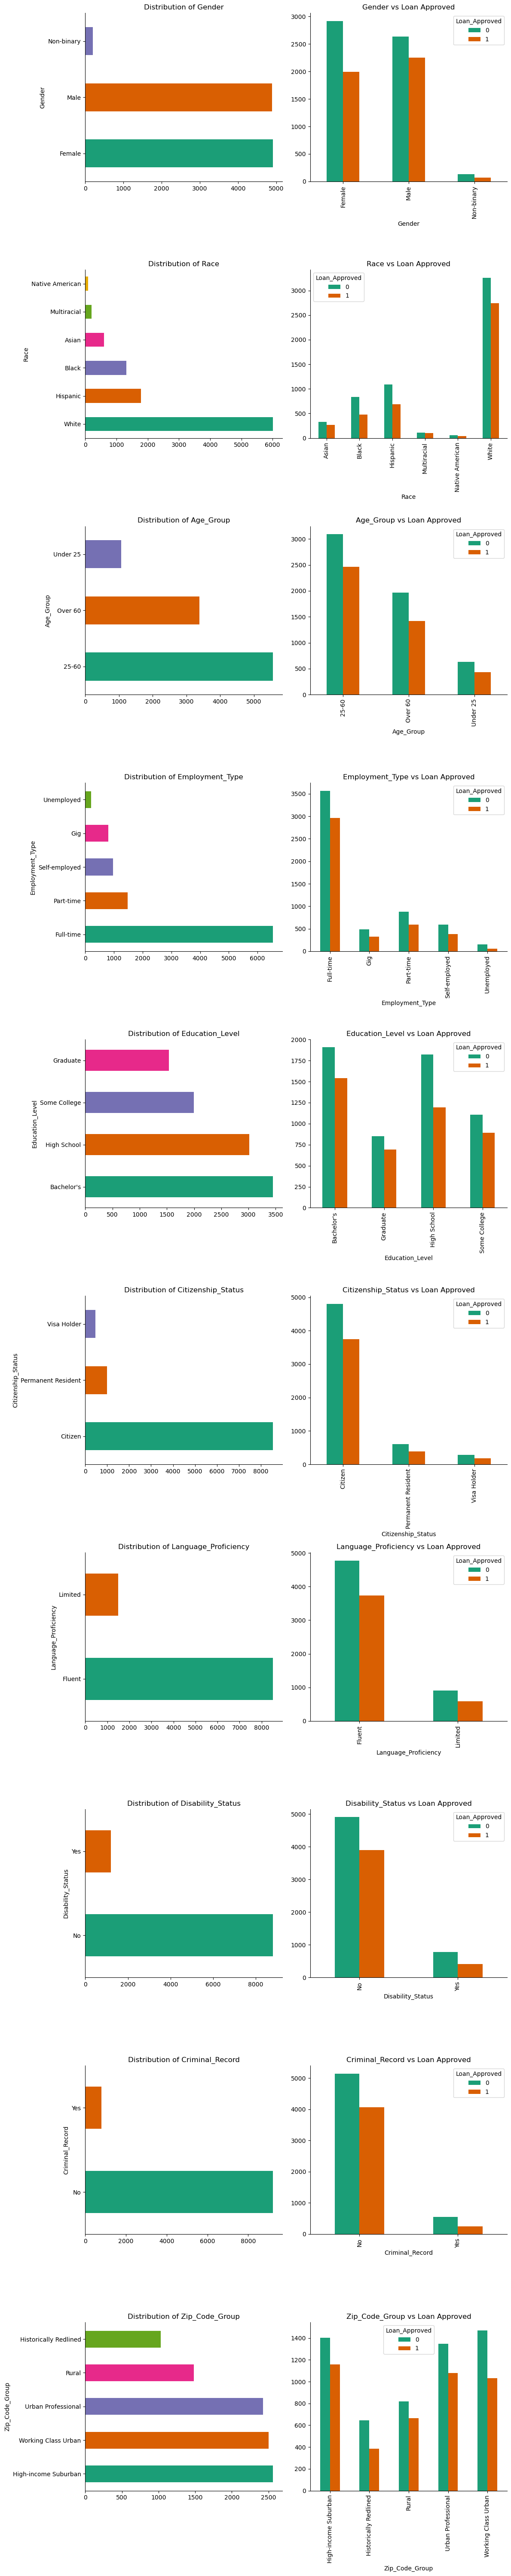

In [ ]:
# Univariate analysis on categorical vars
fig, axes = plt.subplots(nrows=len(categorical_cols), ncols=2, figsize=(12, 6*len(categorical_cols)))
for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='barh', ax=axes[i, 0], color=sns.palettes.mpl_palette('Dark2'))
    axes[i, 0].set_title(f'Distribution of {col}')
    axes[i, 0].spines[['top', 'right']].set_visible(False)
    
    # Multivariate analysis with respect to Loan_Approved
    df.groupby([col, 'Loan_Approved']).size().unstack().plot(kind='bar', ax=axes[i, 1], color=sns.palettes.mpl_palette('Dark2'))
    axes[i, 1].set_title(f'{col} vs Loan Approved')
    axes[i, 1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

2. Univariate and Multivariate Analysis (continuous EDA)

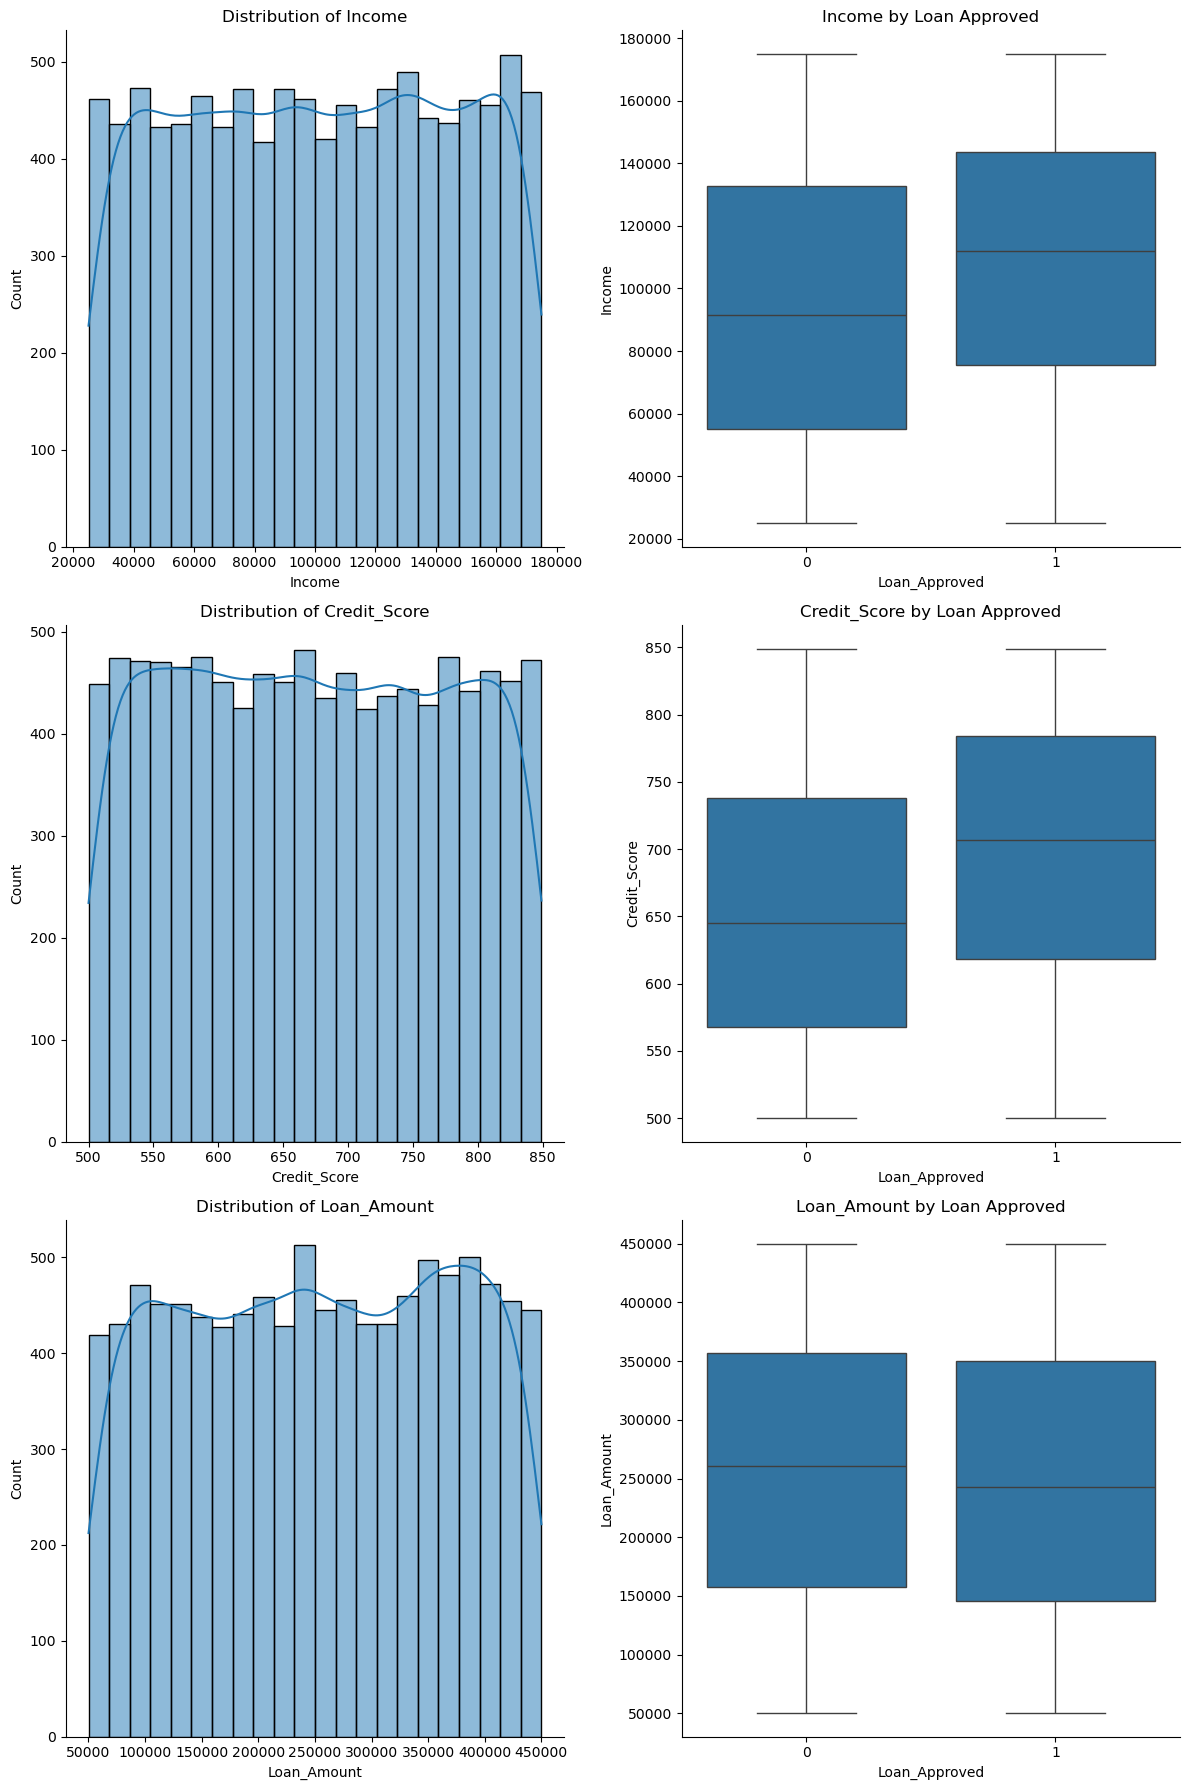

In [ ]:
# Univariate analysis on continuous variables
fig, axes = plt.subplots(nrows=len(continuous_cols), ncols=2, figsize=(12, 6*len(continuous_cols)))
for i, col in enumerate(continuous_cols):
    # Univariate analysis
    sns.histplot(df[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {col}')
    axes[i, 0].spines[['top', 'right']].set_visible(False)
    
    # Multivariate analysis with respect to Loan_Approved
    sns.boxplot(x='Loan_Approved', y=col, data=df, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} by Loan Approved')
    axes[i, 1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

3. grouping the stats

In [ ]:
import tabulate

for col in categorical_cols:
    print(f"Distribution of {col} with respect to Loan_Approved:")
    
    # Table for distribution
    distribution = df.groupby([col, 'Loan_Approved']).size().unstack()
    print(tabulate.tabulate(distribution, headers='keys', tablefmt='psql'))
    
    # Table for % distribution
    percentage_distribution = df.groupby([col, 'Loan_Approved']).size().unstack().div(df.shape[0]).mul(100).round(2)
    print(tabulate.tabulate(percentage_distribution, headers='keys', tablefmt='psql'))
    print()

for col in continuous_cols:
    print(f"Summary statistics of {col} by Loan_Approved:")
    
    # Table for the summary statistics
    summary_stats = df.groupby('Loan_Approved')[col].describe()
    print(tabulate.tabulate(summary_stats, headers='keys', tablefmt='psql'))
    print()

Distribution of Gender with respect to Loan_Approved:
+------------+------+------+
| Gender     |    0 |    1 |
|------------+------+------|
| Female     | 2915 | 1995 |
| Male       | 2635 | 2252 |
| Non-binary |  135 |   68 |
+------------+------+------+
+------------+-------+-------+
| Gender     |     0 |     1 |
|------------+-------+-------|
| Female     | 29.15 | 19.95 |
| Male       | 26.35 | 22.52 |
| Non-binary |  1.35 |  0.68 |
+------------+-------+-------+

Distribution of Race with respect to Loan_Approved:
+-----------------+------+------+
| Race            |    0 |    1 |
|-----------------+------+------|
| Asian           |  327 |  271 |
| Black           |  837 |  476 |
| Hispanic        | 1094 |  686 |
| Multiracial     |  110 |   97 |
| Native American |   54 |   40 |
| White           | 3263 | 2745 |
+-----------------+------+------+
+-----------------+-------+-------+
| Race            |     0 |     1 |
|-----------------+-------+-------|
| Asian           |  3.27

**Findings from EDA:**

Gender:
1. Females: 2915 (29.15%) applied, 1995 (19.95%) approved
2. Males: 2635 (26.35%) applied, 2252 (22.52%) approved
3. Non-binary: 135 (1.35%) applied, 68 (0.68%) approved

Race:
1. White: 3263 (32.63%) applied, 2745 (27.45%) approved
2. Black: 837 (8.37%) applied, 476 (4.76%) approved
3. Hispanic: 1094 (10.94%) applied, 686 (6.86%) approved
4. Asian: 327 (3.27%) applied, 271 (2.71%) approved
5. Multiracial: 110 (1.10%) applied, 97 (0.97%) approved
6. Native American: 54 (0.54%) applied, 40 (0.40%) approved

Age_Group:
1. 25-60: 3091 (30.91%) applied, 2467 (24.67%) approved
2. Over 60: 1963 (19.63%) applied, 1416 (14.16%) approved
3. Under 25: 631 (6.31%) applied, 432 (4.32%) approved


**Approval Rates:**

Gender:
1. Females: 68.4% (1995/2915)
2. Males: 85.5% (2252/2635)
3. Non-binary: 50.37% (68/135)

Race:
1. White: 84.1% (2745/3263)
2. Black: 56.9% (476/837)
3. Hispanic: 62.7% (686/1094)
4. Asian: 82.9% (271/327)
5. Multiracial: 88.2% (97/110)
6. Native American: 74.1% (40/54)

Age_Group:
1. 25-60: 79.8% (2467/3091)
2. Over 60: 72.1% (1416/1963)
3. Under 25: 68.5% (432/631)

Conclusion:
- Whites and Asians have a higher approval rate compared to Blacks and Hispanics.
- Males have a higher approval rate compared to Females.
- Individuals between 25-60 years old have a higher approval rate.

These findings suggest potential biases in the loan approval process. Further analysis, such as regression analysis or fairness metrics (e.g., disparate impact ratio), can help quantify and address these disparities.

In [6]:
print("Loan Approved Rate:", df['Loan_Approved'].mean())

Loan Approved Rate: 0.4315


On checking numerical fields on correlation matrix, found no surprising colinearities

# 3. SNAP analysis and Feature Selection

data processing

In [ ]:
drop_cols = ['ID','Zip_Code_Group','Loan_Approved']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['Loan_Approved']

# Binary encode 2 level sensitive attribute cols like Gender, Disability_Status.
for col in sensitive:
    if X[col].nunique()==2:
        vals = X[col].unique()
        X[col] = X[col].map({vals[0]:0, vals[1]:1})

# One Hot encode other categorical columns
# X = X.drop(columns=sensitive, errors='ignore')  # Drop sensitives
others = X.select_dtypes(include='object').columns.tolist()
X = pd.get_dummies(X, columns=others, drop_first=True)

# Impute missing with KNN instead of mean
imputer = KNNImputer(n_neighbors=5)
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split & scale
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_train)
X_te_s = scaler.transform(X_test)

print("Shapes:", X_tr_s.shape, X_te_s.shape)

Shapes: (8000, 25) (2000, 25)


SHAP logic for last pre-training analysis and feature selection

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

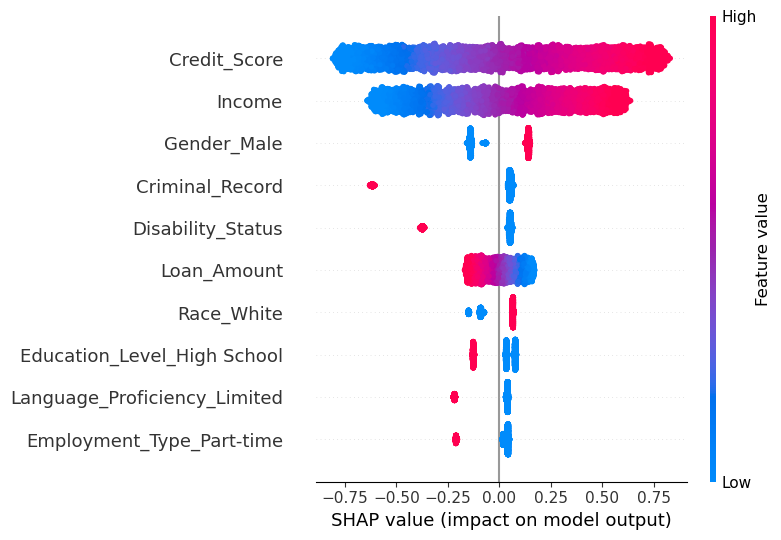

,feature,imp
2,Credit_Score,0.399148
1,Income,0.309171
6,Gender_Male,0.139115
5,Criminal_Record,0.097024
4,Disability_Status,0.090328
3,Loan_Amount,0.081889
12,Race_White,0.078863
20,Education_Level_High School,0.076792
24,Language_Proficiency_Limited,0.065937
16,Employment_Type_Part-time,0.061821


In [16]:
# Train L1 logistic for explanations
base = LogisticRegression(max_iter=200, penalty='l1', solver='liblinear', class_weight='balanced')
base.fit(X_tr_s, y_train)

# SHAP LinearExplainer
explainer = shap.LinearExplainer(base, X_tr_s, feature_perturbation="correlation_dependent")
# interventional or correlation_dependent
shap_vals = explainer.shap_values(X_tr_s)
mean_abs = np.abs(shap_vals).mean(axis=0)
shap_df = pd.DataFrame({'feature': X.columns, 'imp':mean_abs})
shap_df = shap_df.sort_values('imp', ascending=False) # sort by imp
top_features = shap_df.head(20)['feature'].tolist()

# SHAP plot
top_features = shap_df.head(20)['feature'].tolist()
shap.summary_plot(shap_vals, features=X_tr_s, feature_names=X.columns, max_display=10)
shap_df.head(20)

**SHAP insights on features**

Most Important Features : Credit_Score and Income

Notes:
- Male applicants (pink) get a modest upward boost; female/non‑binary (blue) are pushed downward relative to baseline.
- Having a criminal record, Disabled status, High School as education level and Larger loans(pink) decreases approval likelihood so more expected denials
- White applicants (pink) get a slight or modest approval boost
- Part‑time work (pink) marginally hurts approval compared to full‑time (blue).

Cross-check SNAP. This is scenatio based audits. Who is being disadvantaged?

In [ ]:
# Scenario 1: Criminal_Record rate by Gender, Race, Zip
df['Criminal_Flag'] = df['Criminal_Record'].map({'Yes':1, 'No':0})

## Gender
by_gender = df.groupby('Gender')['Criminal_Flag'].mean().rename("Pct_with_Criminal_Record")
print("-> Criminal record rate by Gender:")
print(by_gender)

## Race
by_race = df.groupby('Race')['Criminal_Flag'].mean().rename("Pct_with_Criminal_Record")
print("\n-> Criminal record rate by Race:")
print(by_race)

## Zip Code
by_zip = df.groupby('Zip_Code_Group')['Criminal_Flag'].mean().rename("Pct_with_Criminal_Record")
print("\n-> Criminal record rate by Zip:")
print(by_zip)

# Scenario 2: Average Loan_Amount by Gender and by Race
print("-> Avg Loan_Amount by Gender:")
print(df.groupby('Gender')['Loan_Amount'].mean().round(2))

print("\n-> Avg Loan_Amount by Race:")
print(df.groupby('Race')['Loan_Amount'].mean().round(2))

# Scenario 3: Black applicants: average loan by Approval status
black_df = df[df['Race']=="Black"]

summary_black = black_df.groupby('Loan_Approved')['Loan_Amount'].agg(['count','mean']).rename(columns={'count':'N_samples','mean':'Avg_Loan_Amount'})
print("Black applicants by approval status:")
print(summary_black)

# Scenario 4: Bottom 20% Income approval rate by Gender
threshold = df['Income'].quantile(0.20)
bottom20 = df[df['Income'] <= threshold]

rate_bottom20 = bottom20.groupby('Gender')['Loan_Approved'].mean().rename("Approval_Rate")
print(f"Income <= {threshold:.0f} (bottom 20%) approval by Gender:")
print(rate_bottom20)

# Scenario 5: Approval rate for Disability=Yes AND Criminal_Record=Yes
mask = (df['Disability_Status']=="Yes") & (df['Criminal_Record']=="Yes")
sub = df[mask]

rate = sub['Loan_Approved'].mean()
print(f"Approval rate for disabled & with criminal record: {rate:.3f} " + f"({len(sub)} samples)")


→ Criminal record rate by Gender:
Gender
Female        0.074949
Male          0.082464
Non-binary    0.088670
Name: Pct_with_Criminal_Record, dtype: float64

→ Criminal record rate by Race:
Race
Asian              0.053512
Black              0.080731
Hispanic           0.085393
Multiracial        0.096618
Native American    0.106383
White              0.078063
Name: Pct_with_Criminal_Record, dtype: float64

→ Criminal record rate by Zip:
Zip_Code_Group
High-income Suburban     0.075781
Historically Redlined    0.079689
Rural                    0.083052
Urban Professional       0.086079
Working Class Urban      0.072342
Name: Pct_with_Criminal_Record, dtype: float64
→ Avg Loan_Amount by Gender:
Gender
Female        250835.42
Male          254829.00
Non-binary    245987.33
Name: Loan_Amount, dtype: float64

→ Avg Loan_Amount by Race:
Race
Asian              252149.86
Black              255274.38
Hispanic           251868.42
Multiracial        246301.10
Native American    253239.34
White 

Results:
1. Crime

gender - differences in crime rates between Female (0.0749), Male (0.0825), and Non-binary (0.0887) are relatively small

race - crime has native americans highest, asian least. so crime has a bit race correlation with Native Americans highest (10.6%) and Asians lowest (5.3%).

zip code - not significant

2. Loan Amount

Black Applicants: Denied vs. Approved
Denied Blacks (837 cases): avg $259.7 K

Approved Blacks (476 cases): avg $247.5 K
-> Denied Black applicants asked for roughly $12 K more on average than those approved.

Implication: A modest tilt—denials align with slightly larger requests. But since overall loan‐amounts don’t vary much by race, this alone likely doesn’t explain any larger racial disparities you observe.

3. Bottom‑20% Income Group
Income <= $55 089 (bottom quintile)

Female approval 28.5%, Male 29.9%, Non‑binary 27.3%

Implication: Very low approval rates (< 30%) for the poorest quintile across all genders. Means income is a very strong gatekeeper, but no major gender skew within that low‑income slice.

4. Disabled & Criminal‑Record Intersection
Approval rate for applicants who are both disabled and have a criminal record is only 24.5% (98 people).

Implication: This tiny subpopulation is extremely disadvantaged. That intersection (Disability=Yes & Criminal_Record=Yes) deserves special attention in your fairness audits or targeted mitigation.

**Bottom‑Line Takeaways**

- Race drives the biggest criminal‐record imbalances, not gender.

- Loan size doesn’t differ meaningfully across groups—so it’s unlikely to be the main culprit behind approval gaps.

- Low‐income applicants are almost uniformly unlikely to get approved (< 30%), regardless of gender.

- Disabled + Criminal_Record folks are the most penalized (only 25% approved).

# 4. Final Modeling - Snap pruned features for Logistic Regression

In [10]:
# Pruning features based on SHAP values
X_tr_p = X_train[top_features]
X_te_p = X_test[top_features]
X_tr_ps = scaler.fit_transform(X_tr_p)
X_te_ps = scaler.transform(X_te_p)

# train model on SNAP pruned features
model = LogisticRegression(max_iter=200, penalty='l1',
                           solver='liblinear', class_weight='balanced')
model.fit(X_tr_ps, y_train)
y_base = model.predict(X_te_ps)
print("Accuracy:", accuracy_score(y_test, y_base))
print(classification_report(y_test, y_base))

Accuracy: 0.6315
              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1137
           1       0.56      0.65      0.60       863

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000



# 5. Bias Auditing the trained model

Auditing model's behaviour: Univariate, Intersectional, MetricFrame

In [ ]:

# test df (baseline meaning unpruned)
test_df = pd.DataFrame({'y_true': y_test.reset_index(drop=True),'y_pred': y_base})

# Add sensitive features from original df (unpruned)
for feat in sensitive:
    test_df[feat] = df.loc[X_te_p.index, feat].reset_index(drop=True)

# Univariate audit (baseline)
print("="*3,"Univariate Audit", "="*3)
for feat in sensitive:
    rates = test_df.groupby(feat)['y_pred'].mean()
    print(f"{feat}:")
    print(tabulate.tabulate(rates.to_frame(), headers='keys', tablefmt='psql'))
    print()

# Intersectional audit (baseline) on top-3 sensitive features
top3 = ['Criminal_Record', 'Gender', 'Disability_Status']
test_df['group'] = test_df[top3].astype(str).agg('-'.join, axis=1)
counts = test_df['group'].value_counts()
valid = counts[counts >= 30].index
print("\nIntersectional (n >= 30):")
print(tabulate.tabulate(test_df.loc[test_df['group'].isin(valid)].groupby('group')['y_pred'].mean().to_frame(), headers='keys', tablefmt='psql'))

# MetricFrame disparities (selection rate & FNR)
print("\n", "="*3, "MetricFrame Disparities", "="*3)
for feat in top3:
    mf = MetricFrame(
        metrics={'sr': selection_rate, 'fnr': false_negative_rate},
        y_true=test_df['y_true'],
        y_pred=test_df['y_pred'],
        sensitive_features=test_df[feat]
    )
    print(f"\nBy {feat}:")
    print(tabulate.tabulate(mf.by_group, headers='keys', tablefmt='psql'))
    print("Diff:")
    print(tabulate.tabulate(mf.difference().to_frame(), headers='keys', tablefmt='psql'))

=== Univariate Audit ===
Gender:
+------------+----------+
| Gender     |   y_pred |
|------------+----------|
| Female     | 0.423415 |
| Male       | 0.592751 |
| Non-binary | 0.27027  |
+------------+----------+

Race:
+-----------------+----------+
| Race            |   y_pred |
|-----------------+----------|
| Asian           | 0.473684 |
| Black           | 0.38676  |
| Hispanic        | 0.395894 |
| Multiracial     | 0.454545 |
| Native American | 0.705882 |
| White           | 0.558062 |
+-----------------+----------+

Age_Group:
+-------------+----------+
| Age_Group   |   y_pred |
|-------------+----------|
| 25-60       | 0.529467 |
| Over 60     | 0.46505  |
| Under 25    | 0.469565 |
+-------------+----------+

Citizenship_Status:
+----------------------+----------+
| Citizenship_Status   |   y_pred |
|----------------------+----------|
| Citizen              | 0.512464 |
| Permanent Resident   | 0.431694 |
| Visa Holder          | 0.402174 |
+----------------------+------

**Univariate Analysis**

- Gender: Males have the highest predicted approval rate. Potentially biased against non-males
- Race: The lowest rates are for Black (y_pred = 0.38676) and Hispanic (y_pred = 0.395894)
- Age Group: Differences are not stark
- Citizenship: Citizens have the highest predicted approval rate (y_pred = 0.512464). Then Permanent Residents (y_pred = 0.431694), and then Visa Holders (y_pred = 0.402174), suggesting potential biases against non-citizens.
- Disabled: Those without disability have higher rate (y_pred = 0.531073) compared to those with a disability (y_pred = 0.26087), indicating a possible bias
- Criminal record: Applicants without have y_pred = 0.527174 while with a record have 0.1875 but this can be a policy.

**Intersectional Analysis**

- 'No-Female-No' has a predicted approval rate y_pred = 0.478839. 'No-Male-No' has an even higher rate y_pred = 0.661458
- 'No-Non-binary-No' is close to 'Yes-Male-No', y_pred as 0.266667 and 0.212121 respectively.


**MetricFrame Disparities**

- Criminal Record: Those without a record have a much higher selection_rate (0.527174) and lower false_negative_rate (0.320099) compared to those with a record.
- Gender: Males have the highest sr (0.592751) and lowest fnr (0.254762), while non-binary have the lowest sr (0.27027) and highest fnr (0.5625).
- Disabilities: Significant disparity


# 9. Fairness Metrics (aif360, disparate impact)

Disparate Impact: 1.3999
AUC: 0.6777


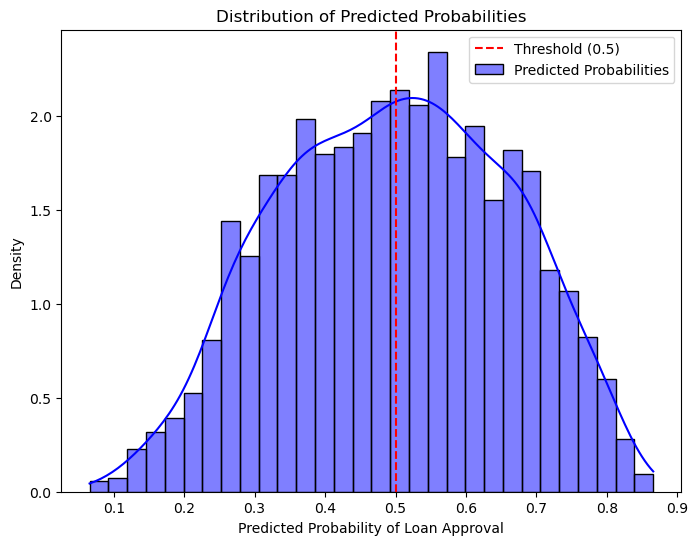

In [ ]:
# Recover sensitive test features from original df because they were pruned
sf_test = df.loc[X_te_p.index, sensitive].reset_index(drop=True)
sf_test_enc = sf_test.copy()
for c in sensitive:
    if sf_test_enc[c].dtype == 'object':
        sf_test_enc[c] = pd.factorize(sf_test_enc[c])[0]

# Prepare DF for AIF360
df_for_aif_test = pd.concat([
    X_te_p.reset_index(drop=True),
    sf_test_enc,
    y_test.reset_index(drop=True).rename("Loan_Approved")
], axis=1)

# Created BinaryLabelDataset from test data
aif_test = BinaryLabelDataset(
    df=df_for_aif_test,
    label_names=['Loan_Approved'],
    protected_attribute_names=sensitive
)

# Assigned baseline model predictions to AIF copy
aif_pred = aif_test.copy()
aif_pred.labels = y_base.reshape(-1, 1)

# Compute Disparate Impact for Gender
metric = BinaryLabelDatasetMetric(
    aif_pred,
    unprivileged_groups=[{'Gender': 0}],
    privileged_groups=[{'Gender': 1}]
)
print("Disparate Impact:", round(metric.disparate_impact(), 4))

# AUC using (predicted probabilities from) baseline model predictions
y_base_proba = model.predict_proba(X_te_ps)[:, 1]
print("AUC:", round(roc_auc_score(y_test, y_base_proba), 4))
# Visualize AUC
plt.figure(figsize=(8, 6))
sns.histplot(y_base_proba, bins=30, kde=True, color='blue',
             stat='density', label='Predicted Probabilities')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Loan Approval')
plt.ylabel('Density')
plt.legend()
plt.show()


roughly normal distribution. AUC of 0.6777 shows the model can ~reasonably distinguish the applicants loan approval status but being close to 0.5 shows it is essentially guessing in imbalanced data

In [ ]:
from sklearn.metrics import balanced_accuracy_score
# Balanced accuracy from baseline predictions
print("Balanced accuracy (baseline):", balanced_accuracy_score(y_test, y_base))

Balanced Accuracy (baseline): 0.634015333800094
AUC (baseline): 0.6777


Balanced Accuracy 0.634 shows a moderate ability to distinguish between classes

In [ ]:
# Disparate Impact for sensitive attributes. It compares the rate of loan approval (true positives) between privileged and unprivileged groups.
for attr in sensitive:
    unpriv = [{attr: 0}]
    priv =   [{attr: 1}]
    metric = BinaryLabelDatasetMetric(aif_pred, unpriv, priv)
    print(f"{attr} Disparate Impact = {metric.disparate_impact():.4f}")

Gender Disparate Impact = 1.3999
Race Disparate Impact = 1.2277
Age_Group Disparate Impact = 1.1385
Citizenship_Status Disparate Impact = 1.1871
Disability_Status Disparate Impact = 2.0358
Criminal_Record Disparate Impact = 2.8116


Disability_Status and Criminal_Record exhibit very high DI, with privileged groups being approved over 2–2.8x more often, violating fairness thresholds. The rest lie within 0.8 to 1.25 rule so generally acceptable.

In [3]:
import pandas as pd

df1 = pd.read_csv("dataset/test.csv", encoding='latin1')
# Check if the DataFrame has empty values
df1.isnull().sum()

ID                      0
Gender                  0
Race                    0
Age                     0
Age_Group               0
Income                  0
Credit_Score            0
Loan_Amount             0
Employment_Type         0
Education_Level         0
Citizenship_Status      0
Language_Proficiency    0
Disability_Status       0
Criminal_Record         0
Zip_Code_Group          0
dtype: int64